In [1]:
# import sys
# !{sys.executable} -m pip install scipy

In [2]:
import json
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt

figsize = (10,6)
pktPayloadSize = 1460 # Bytes
hdrSize = 40 #Bytes
torBw = 10e9 # bps
coreBw = 40e9 # bps

oneWayDel = 1.0e-6 \
         + (pktPayloadSize+hdrSize)*8*(2/torBw + 2/coreBw)
baseRtt = oneWayDel \
         + 1.0e-6 + hdrSize*8*(2/torBw + 2/coreBw)
print("OneWayDelay: {} BaseRTT: {}".format(oneWayDel,baseRtt))

bdpPkts = 7

OneWayDelay: 4e-06 BaseRTT: 5.08e-06


In [3]:
def removeKey(d, key):
    r = dict(d)
    del r[key]
    return r

In [4]:
def getPctl(a, p):
    i = int(len(a) * p)
    return a[i]

# Importing the NS3 Simulation Data

In [5]:
workloadName = '_W5'
workloadSource = 'DCTCP'
networkLoad = 0.5
simName = workloadName + '_load-' + str(int(networkLoad*100)) + 'p'
numSim = 4
# folderName = str(numSim)+"-parallel-sims-noRtx/"
folderName = "./"
plotQueueFigures = False
saturationTime = 3.1

In [6]:
msgStartEntryDict = {}
msgCompletionTimesDict = {}
allMsgSizes = []

for i in range(numSim):
    with open(folderName+"MsgTraces"+simName+"_"+str(i)+".tr",'r') as f:
        for line in f:
            msgLog = line.split()

            time = float(msgLog[1])*1e-9        # in seconds
            msgSize = int(msgLog[2])#//1462*1462 # in bytes
            sender = msgLog[3]                  # ip:port
            receiver = msgLog[4]                # ip:port
            txMsgId = int(msgLog[5])

            key = (sender, receiver, txMsgId, i)

            if (msgLog[0]=='+'):
                if (key in msgStartEntryDict):
                    msgStartEntryDict[key].append(time)
                else:
                    msgStartEntryDict[key] = [time]

            elif (msgLog[0] =='-'):
                if (key in msgStartEntryDict):
                    startTime = msgStartEntryDict[key].pop()
                    if (len(msgStartEntryDict[key]) <= 0):
                        msgStartEntryDict = removeKey(msgStartEntryDict, key)

                    if(startTime < saturationTime):
                        continue
                
                    if (msgSize in msgCompletionTimesDict):
                        msgCompletionTimesDict[msgSize].append(time-startTime)
                    else:
                        msgCompletionTimesDict[msgSize] = [time-startTime]
                    allMsgSizes.append(msgSize)
                else:
                    print('ERROR: Start entry of message (' \
                          + sender + ' > ' + receiver + ', ' + str(txMsgId) \
                          + ') not found!')
allMsgSizes = np.array(allMsgSizes)
msgSizePercentiles = stats.rankdata(allMsgSizes, 'max')/len(allMsgSizes)*100

In [7]:
i = 0
for msgKey, msgStartTimes in msgStartEntryDict.items():
#     print(msgKey, ' : ', msgStartTimes)
    i += len(msgStartTimes)
print ('Number of uncompleted messages: ' + str(i))

Number of uncompleted messages: 0


In [8]:
# print (json.dumps(msgCompletionTimesDict, sort_keys=True, indent=4))

In [9]:
print('Number of distinct message sizes: ' + str(len(msgCompletionTimesDict)))

cntMultMeasures = 0
numMsgs = 0
nonFullPacketMsgSizes = []
for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    if (len(msgCompletionTimes)>1):
        cntMultMeasures += 1
    
    numMsgs += len(msgCompletionTimes)
    
    if (msgSize%pktPayloadSize != 0):
        nonFullPacketMsgSizes.append((msgSize,msgSize%pktPayloadSize))
    
print('Number of distinct message sizes that '\
      +'have multiple measurements: ' + str(cntMultMeasures))   
print('Number of distinct messages: ' + str(numMsgs)) 

if (nonFullPacketMsgSizes):
    print('Non-Full Packet Message Sizes: ', nonFullPacketMsgSizes)

Number of distinct message sizes: 400
Number of distinct message sizes that have multiple measurements: 399
Number of distinct messages: 52468


In [10]:
SimMsgSizes = []
SimP50CompletionTimes = []
SimP99CompletionTimes = []
SimBaseCompletionTimes = []
SimP50SlowDowns = []
SimP99SlowDowns = []

for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    SimMsgSizes.append(msgSize)
    
    times = np.array(msgCompletionTimes)
    p50CompletionTime = np.percentile(times,50)
    SimP50CompletionTimes.append(p50CompletionTime)
    p99CompletionTime = np.percentile(times,99)
    SimP99CompletionTimes.append(p99CompletionTime)
#     times = sorted(msgCompletionTimes)
#     p50CompletionTime = getPctl(times, 0.5)
#     SimP50CompletionTimes.append(p50CompletionTime)
#     p99CompletionTime = getPctl(times, 0.99)
#     SimP99CompletionTimes.append(p99CompletionTime)
    
    totBytes = msgSize + math.ceil(msgSize / pktPayloadSize) * (hdrSize) 
    baseCompletionTime = totBytes * 8 / torBw;
    if (msgSize > bdpPkts * pktPayloadSize):
        baseCompletionTime += oneWayDel
    else:
        baseCompletionTime += oneWayDel
#     baseCompletionTime = (totBytes+pktPayloadSize)*8.0/10e9 + 0.5e-6 \
#                           + 2*pktPayloadSize*8.0/40e9 + 0.5e-6
    
    SimBaseCompletionTimes.append(baseCompletionTime)
    
    SimP50SlowDowns.append(p50CompletionTime / baseCompletionTime)
    SimP99SlowDowns.append(p99CompletionTime / baseCompletionTime)

#     slowDowns = times / baseCompletionTime
#     slowDowns = np.where(slowDowns < 1.0, 1.0, slowDowns)

#     SimP50SlowDowns.append(np.percentile(slowDowns,50))
#     SimP99SlowDowns.append(np.percentile(slowDowns,99))
    
zipData = sorted(zip(SimMsgSizes,
                     SimP50CompletionTimes,
                     SimP99CompletionTimes,
                     SimBaseCompletionTimes,
                     SimP50SlowDowns,
                     SimP99SlowDowns))
    
SimMsgSizes = np.array([x for x,_,_,_,_,_ in zipData])
SimP50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
SimP99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])
SimBaseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])
SimP50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
SimP99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

# Importing the Original Raw Data from the Paper

In [11]:
homaPercent = 0
origMsgSizeCumPercents = []
origP50SlowDowns = []
origP99SlowDowns = []
pfabricPercent = 0
pfabricMsgSizeCumPercents = []
pfabricP50SlowDowns = []
pfabricP99SlowDowns = []
with open("../../../inputs/homa-paper-reproduction/original-raw-data-from-paper.txt",'r') as f:
    for line in f:
        rawEntry = line.split()
        
        protocol = rawEntry[0]
        if (protocol=='TransportType'):
            continue
            
        loadFactor = float(rawEntry[1])
        workload = rawEntry[2]
        sizeCntPercent = float(rawEntry[4])
        medianSlowDown = float(rawEntry[8]) if rawEntry[8]!='NA' else None
        tailSlowDown = float(rawEntry[9]) if rawEntry[9]!='NA' else None
        
        if (protocol == 'Homa' \
             and loadFactor == networkLoad \
             and workload == workloadSource \
             and (medianSlowDown or tailSlowDown)):
            
            if (medianSlowDown):
                homaPercent += sizeCntPercent 
                origMsgSizeCumPercents.append(homaPercent)
                origP50SlowDowns.append(medianSlowDown)
            elif (tailSlowDown):
                origP99SlowDowns.append(tailSlowDown)
                
        if (protocol == 'pFabric' \
             and loadFactor == networkLoad \
             and workload == workloadSource \
             and (medianSlowDown or tailSlowDown)):
            
            if (medianSlowDown):
                pfabricPercent += sizeCntPercent 
                pfabricMsgSizeCumPercents.append(pfabricPercent)
                pfabricP50SlowDowns.append(medianSlowDown)
            elif (tailSlowDown):
                pfabricP99SlowDowns.append(tailSlowDown)

# Plotting the Slowdown Curves

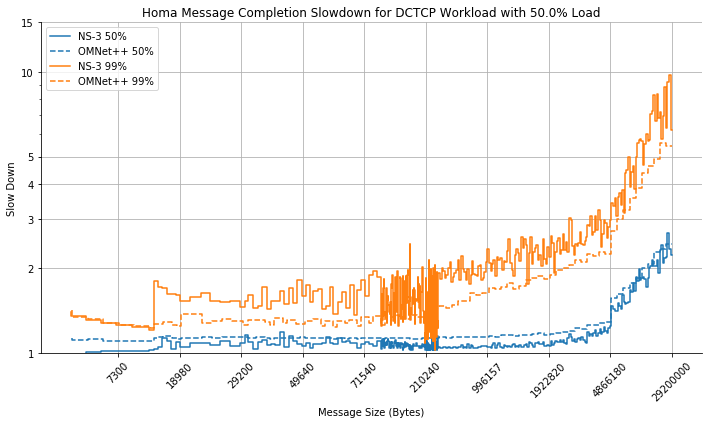

In [12]:
plt.figure(figsize=figsize)
plt.grid()

x = [msgSizePercentiles[np.where(allMsgSizes == i)[0][0]] for i in SimMsgSizes]
plt.step(x,SimP50SlowDowns, label='NS-3 50%', color='C0')
plt.step(origMsgSizeCumPercents,origP50SlowDowns, label='OMNet++ 50%',
          linestyle='--', color='C0')
# plt.step(pfabricMsgSizeCumPercents,pfabricP50SlowDowns, label='pFabric 50%',
#           linestyle='--', color='C3')
plt.step(x,SimP99SlowDowns,label='NS-3 99%', color='C1')
plt.step(origMsgSizeCumPercents,origP99SlowDowns, label='OMNet++ 99%',
          linestyle='--', color='C1')
# plt.step(pfabricMsgSizeCumPercents,pfabricP99SlowDowns, label='pFabric 99%',
#           linestyle=':', color='C3')

plt.ylabel('Slow Down')
plt.xlabel('Message Size (Bytes)')
plt.title('Homa Message Completion Slowdown for ' + \
          workloadSource + ' Workload with ' + \
          str(networkLoad*100) + '% Load')
plt.legend(loc='upper left')

xTickPercentiles = np.linspace(10, 100, 10)
xticks = np.percentile(allMsgSizes,xTickPercentiles).astype(int) 
plt.xticks(xTickPercentiles, xticks, rotation=45)

plt.yscale('log')
yticks = None
if (networkLoad==0.5):
    yticks = [1,2,3,4,5,10,15]
    plt.ylim([1,15])
elif (networkLoad==0.8):
    yticks = [1,2,3,4,5,10,20,30]
    plt.ylim([1,30])
if (yticks):
    plt.yticks(yticks, yticks)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

plt.savefig(folderName+'MsgComletionSlowdown'+simName+'.png')
plt.show()

# Importing the NS3 Queue Size Data

In [13]:
if (plotQueueFigures):
    queueTracesDict = {}

    maxQueueSize = 0
    selectedHostIdx = 0

    for i in range(1):
        with open(folderName+"MsgTraces"+simName+"_"+str(i)+".qlen",'r') as f:
            for line in f:
                qLog = line.split()

                time = float(qLog[0])*1e-9        # in seconds
                hostIdx = int(qLog[1].split('=')[1])
                qSize = float(qLog[2].split('=')[1])/1e3 #in KBytes

                if (qSize > maxQueueSize):
                    maxQueueSize = qSize
                    selectedHostIdx = hostIdx

                if (hostIdx in queueTracesDict):
                    queueTracesDict[hostIdx]['time'].append(time)
                    queueTracesDict[hostIdx]['qSize'].append(qSize)
                else:
                    queueTracesDict[hostIdx] = {}
                    queueTracesDict[hostIdx]['time'] = [time]
                    queueTracesDict[hostIdx]['qSize'] = [qSize]

In [14]:
if (plotQueueFigures):
    plt.figure(figsize=figsize)
    plt.grid()

    # for hostIdx, qTrace in queueTracesDict.items():
    #     plt.plot(qTrace['time'], qTrace['qSize'], label=hostIdx)
    #     break
    hostIdxToPlot = selectedHostIdx
    plt.plot(queueTracesDict[hostIdxToPlot]['time'], 
             queueTracesDict[hostIdxToPlot]['qSize'], 
             label=hostIdxToPlot)

    plt.xlabel('Time (sec)')
    plt.ylabel('Queue Size (KBytes)')
    plt.title('The Queue Trace of the ToR Switch for ' + \
              workloadSource + ' Workload with ' + \
              str(networkLoad*100) + '% Load')
    plt.legend(title='Host Idx')

    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.tight_layout()

    plt.show()

In [15]:
if (plotQueueFigures):
    for hostIdx, qTrace in queueTracesDict.items():
        plt.figure(figsize=figsize)
        plt.grid()

        plt.plot(qTrace['time'], qTrace['qSize'], label=hostIdx)

        plt.xlabel('Time (sec)')
        plt.ylabel('Queue Size (KBytes)')
        plt.title('The Queue Trace of the ToR Switch for ' + \
                  workloadSource + ' Workload with ' + \
                  str(networkLoad*100) + '% Load')
        plt.legend(title='Host Idx')

        plt.gca().spines["right"].set_visible(False)
        plt.gca().spines["top"].set_visible(False)
        plt.tight_layout()

        plt.show()

# Alternative Way of Generating Slow Down Figures

In [16]:
step = 1

In [17]:
zipData = []

for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    baseCompletionTime = (msgSize+pktPayloadSize)*8.0/10e9 + 0.5e-6 \
                          + 2*pktPayloadSize*8.0/40e9 + 0.5e-6
    
    for completionTime in msgCompletionTimes:
        zipData.append((msgSize,completionTime/baseCompletionTime))
        
zipData = sorted(zipData)
allSimMsgSizes = [x for x,_ in zipData]
allSimSlowDowns = [x for _,x in zipData]

In [18]:
res = [[i/100.] for i in range(0, 100, step)]
nMsgs = len(allSimMsgSizes)
for i in range(0,100,step):
    l = int(i * nMsgs / 100)
    r = int((i+step) * nMsgs / 100)
    msOfThisStep = allSimMsgSizes[l:r]
    sdOfThisStep = sorted(allSimSlowDowns[l:r])
    res[int(i/step)].append(msOfThisStep[-1]) # flow size
    #res[int(i/step)].append(sum(sdOfThisStep) / len(sdOfThisStep)) # avg fct
    res[int(i/step)].append(getPctl(sdOfThisStep, 0.5)) # mid fct
    res[int(i/step)].append(getPctl(sdOfThisStep, 0.95)) # 95-pct fct
    res[int(i/step)].append(getPctl(sdOfThisStep, 0.99)) # 99-pct fct
allSimMsgSizePctls = np.array([100*x+step for x,_,_,_,_ in res])
allSimMsgSizes = np.array([x for _,x,_,_,_ in res])
allSimMedSlowDowns = np.array([x for _,_,x,_,_ in res])
allSimSlowDowns95p = np.array([x for _,_,_,x,_ in res])
allSimSlowDowns99p = np.array([x for _,_,_,_,x in res])

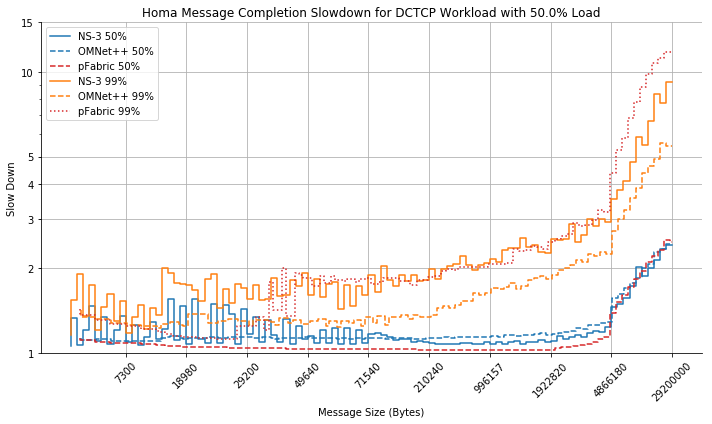

In [19]:
plt.figure(figsize=figsize)
plt.grid()

plt.step(allSimMsgSizePctls,allSimMedSlowDowns, label='NS-3 50%', color='C0')
plt.step(origMsgSizeCumPercents,origP50SlowDowns, label='OMNet++ 50%',
          linestyle='--', color='C0')
plt.step(pfabricMsgSizeCumPercents,pfabricP50SlowDowns, label='pFabric 50%',
          linestyle='--', color='C3')
plt.step(allSimMsgSizePctls,allSimSlowDowns99p,label='NS-3 99%', color='C1')
plt.step(origMsgSizeCumPercents,origP99SlowDowns, label='OMNet++ 99%',
          linestyle='--', color='C1')
plt.step(pfabricMsgSizeCumPercents,pfabricP99SlowDowns, label='pFabric 99%',
          linestyle=':', color='C3')

plt.ylabel('Slow Down')
plt.xlabel('Message Size (Bytes)')
plt.title('Homa Message Completion Slowdown for ' + \
          workloadSource + ' Workload with ' + \
          str(networkLoad*100) + '% Load')
plt.legend(loc='upper left')

xTickPercentiles = np.linspace(10, 100, 10)
xticks = np.percentile(allMsgSizes,xTickPercentiles).astype(int) 
plt.xticks(xTickPercentiles, xticks, rotation=45)

plt.yscale('log')
yticks = None
if (networkLoad==0.5):
    yticks = [1,2,3,4,5,10,15]
    plt.ylim([1,15])
elif (networkLoad==0.8):
    yticks = [1,2,3,4,5,10,20,30]
    plt.ylim([1,30])
if (yticks):
    plt.yticks(yticks, yticks)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

# plt.savefig(folderName+'MsgComletionSlowdown'+simName+'.png')
plt.show()